In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint, adfuller
from pmdarima import auto_arima
from arch import arch_model
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
from copulalib.copulalib import Copula
from array import array 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
import arch

## 1. Importing Data

In [2]:
# Importing Data
bit_data = yf.download(tickers = 'BTC-USD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
gld_data = yf.download(tickers = 'GLD', start = "2020-04-01", end = "2021-01-01", interval = '1d')
vgk_data = yf.download(tickers = 'VGK', start = "2020-04-01", end = "2021-01-01", interval = '1d')

# Concatenating the adjusted close prices together
adj_close_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])
adj_close_data['BTC'] = bit_data['Adj Close']
adj_close_data['GLD'] = gld_data['Adj Close']
adj_close_data['VGK'] = vgk_data['Adj Close']

# Filling NaN Values with forward-filling
adj_close_data.fillna(method = "ffill", axis = 0, inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2. Data Processing and Calculating Returns

In [3]:
ret_data = pd.DataFrame(columns = ['BTC', 'GLD', 'VGK'])

# Calculating daily returns for GOLD ETF
ret_data['BTC'] = np.log(adj_close_data['BTC']) - np.log(adj_close_data['BTC'].shift(1))

# Calculating daily returns for GOLD ETF
ret_data['GLD'] = np.log(adj_close_data['GLD']) - np.log(adj_close_data['GLD'].shift(1))

# Calculating daily returns for EQUITY ETF
ret_data['VGK'] = np.log(adj_close_data['VGK']) - np.log(adj_close_data['VGK'].shift(1))

ret_data.dropna(inplace = True)
ret_data

,BTC,GLD,VGK
Date,,,
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021088
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
2020-04-06,0.068384,0.027334,0.048225
...,...,...,...
2020-12-28,0.030458,-0.003636,0.006789
2020-12-29,0.010198,0.003636,0.007235
2020-12-30,0.052625,0.007626,-0.001312


## 3. Data Summaries Extreme Values

#### 3.1 Compute the returns for each series.


In [4]:
# Computing the return of each return series 
btc_tot_ret = ret_data['BTC'].sum()
gld_tot_ret = ret_data['GLD'].sum()
vgk_tot_ret = ret_data['VGK'].sum()

print("Bitcoin's return for the given period is: {} %".format(np.round(btc_tot_ret*100, 3)))
print("Gold ETF's return for the given period is: {} %".format(np.round(gld_tot_ret*100, 3)))
print("Equity ETF's return for the given period is: {} %".format(np.round(vgk_tot_ret*100, 3)))
print("")


Bitcoin's return for the given period is: 149.202 %
Gold ETF's return for the given period is: 17.684 %
Equity ETF's return for the given period is: 40.05 %



#### 3.2 Similarly, compute the kurtosis for each series.

In [5]:
# Computing the kurtosis of each return series 
btc_kurt = ret_data['BTC'].kurtosis()
gld_kurt = ret_data['GLD'].kurtosis()
vgk_kurt = ret_data['VGK'].kurtosis()

print("Bitcoin's kurtosis for the given period is: {}".format(btc_kurt))
print("Gold ETF's kurtosis for the given period is: {}".format(gld_kurt))
print("Equity ETF's kurtosis for the given period is: {}".format(vgk_kurt))
print("")

Bitcoin's kurtosis for the given period is: 2.7611936882111117
Gold ETF's kurtosis for the given period is: 7.85067699084473
Equity ETF's kurtosis for the given period is: 4.103836563660474



#### 3.3 Use a common metric (BUT NOT 2 SIGMA), or derive your own, to identify an extreme value.  Explain your reasoning.

Here we use the Z Score method for finding the extreme values, meaning that when a values is 3 standard deviations away from the mean of our data series we consider that an extreme, probably rare, realization of the data generating process.

#### 3.4 Apply your metric to each of the return series.

In [6]:
# 3.3 - 3.4 Using z-score method for finding extreme values

# BTC 
btc_high_bound =  ret_data['BTC'].mean() + 3*ret_data['BTC'].std()
btc_low_bound  =  ret_data['BTC'].mean() - 3*ret_data['BTC'].std()
btc_outliers = ret_data['BTC'][(ret_data['BTC'] >= btc_high_bound) | (ret_data['BTC'] <= btc_low_bound)]
print("BTC outlier returns are: ")
print(btc_outliers*100)

# GLD 
gld_high_bound =  ret_data['GLD'].mean() + 3*ret_data['GLD'].std()
gld_low_bound  =  ret_data['GLD'].mean() - 3*ret_data['GLD'].std()
gld_outliers = ret_data['GLD'][(ret_data['GLD'] >= gld_high_bound) | (ret_data['GLD'] <= gld_low_bound)]
print("GLD outlier returns are: ")
print(gld_outliers*100)

# VGK 
vgk_high_bound =  ret_data['VGK'].mean() + 3*ret_data['VGK'].std()
vgk_low_bound  =  ret_data['VGK'].mean() - 3*ret_data['VGK'].std()
vgk_outliers = ret_data['VGK'][(ret_data['VGK'] >= vgk_high_bound) | (ret_data['VGK'] <= vgk_low_bound)]
print("VGK outlier returns are: ")
print(vgk_outliers*100)

BTC outlier returns are: 
Date
2020-04-29    11.984141
2020-05-10    -9.133875
2020-07-27    10.400867
2020-09-03   -10.802491
2020-11-05     9.741581
2020-11-26    -8.820525
2020-12-16     9.305160
Name: BTC, dtype: float64
GLD outlier returns are: 
Date
2020-08-11   -5.518973
2020-08-19   -3.207438
2020-11-09   -4.528086
Name: GLD, dtype: float64
VGK outlier returns are: 
Date
2020-04-06    4.822477
2020-04-15   -4.173808
2020-05-18    4.420724
2020-06-11   -6.042110
2020-10-28   -3.935259
Name: VGK, dtype: float64


## 4. Data Comparison Copulas

#### 4.1 Pick 2 of the series  that had the most extreme values.
Here, we chose the VGK ETF and Bitcoin given that they had the most extreme values.

In [7]:
# Utility methods to calculate the returns of a provided quarter

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def get_day_before(year, month):
    return (datetime(year, month, 1).date() - timedelta(days=1)).strftime('%Y-%m-%d')

def get_data(df, year_start, year_end, month_start, month_end):
    return df.loc[f"{year_start}-{month_start:02d}-01": get_day_before(year_end, month_end)]

In [8]:
# Extract quarter 2 data to be plotted
q2_returns = get_data(ret_data, 2020, 2020, 4, 7)
q2_returns

,BTC,GLD,VGK
Date,,,
2020-04-02,0.027889,0.016261,0.018911
2020-04-03,-0.008906,0.004925,-0.021088
2020-04-04,0.019726,0.000000,0.000000
2020-04-05,-0.011187,0.000000,0.000000
2020-04-06,0.068384,0.027334,0.048225
...,...,...,...
2020-06-26,-0.011059,0.004453,-0.016931
2020-06-27,-0.012909,0.000000,0.000000
2020-06-28,0.010797,0.000000,0.000000


#### 4.2 Graph the returns of those 2 series on an x-y plot.  Feel free to use either an individual quarter, or several quarters.
- Selected Quarter: Q2 2020

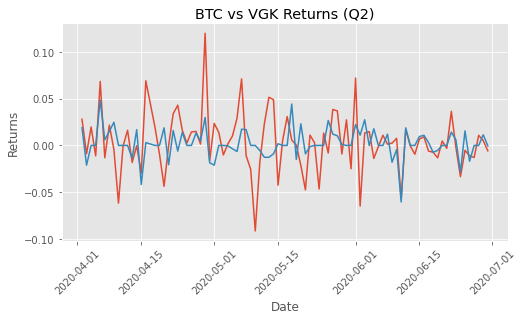

In [9]:
import matplotlib.pyplot as plt

# Change color theme
plt.style.use('ggplot')

# Plot figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(q2_returns.index, q2_returns.BTC)
ax.plot(q2_returns.index, q2_returns.VGK)

# Setting the title
ax.set_title("BTC vs VGK Returns (Q2)")

# Setting the ylabels and xlabels
ax.set_ylabel('Returns')
ax.set_xlabel('Date')

# Rotate xticks
plt.xticks(rotation = 45)

plt.show()

#### 4.3 Fit a non-Gaussian copula to the returns of those 2 series.  (Selected Copula: Clayton)

- Selected Quarter: Q2 2020

In [10]:
from copulalib.copulalib import Copula
from array import array 

dataset = q2_returns[q2_returns.VGK != 0] # remove non-trading days for VGK

# Visualise data in scatterplot and histograms
def plotDistributions(x, y):
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(x, bins=20, color='green', alpha=0.8, align='mid')
    plt.title('BTC returns distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(x, y, marker="o", alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint X,Y')
    plt.hist(y, bins=20, orientation='horizontal', color='red', alpha=0.8, align='mid')
    plt.title('VGK returns distribution')    
    plt.show()
    
# Generate Clayton Copula
def plotClaytonCopula(x, y):
    fig = plt.figure()
    clayton = Copula(x, y, family='clayton')
    uc, vc = clayton.generate_uv(500)
    fig.add_subplot(2,2,2)
    plt.scatter(uc,vc,marker='.', s=5, color='red')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.title('Clayton Copula')
    plt.show()

Non-Gaussian Copula of BTC & VGK (Quarter 2)

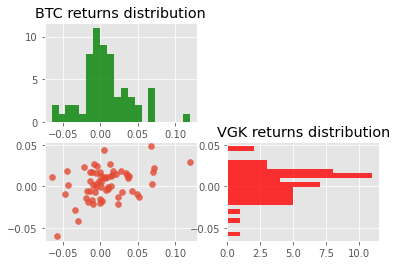

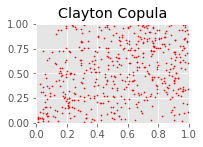

In [11]:
plotDistributions(dataset.BTC, dataset.VGK)
plotClaytonCopula(dataset.BTC, dataset.VGK)

Non-Gaussian Coupula of VGK

## 5. Category 1 Models: Just use 1 variable.
### 5.1 - 5.2 - 5.3 - 5.4

We will develope two strategies, first we use an ARMA model to predict the future returns and generate buying and selling signals. Then in the second one, we use some sort of Volatility Trading startegy using GARCH, meaning that we will forecast future volatility and produce signals off of that.

The rationale in the ARMA strategy is buying when the the predicted return is positive and selling when the predicted return is negative. In the GARCH strategy, we will buy in periods of low volatility and sell in periods of high volatility or in other words, high risk.

The setting for our backtesting is very simple and straight-foreward, we invest our whole money in each buy order, and by selling we pull out our money out of the market, meaning that there won't be any shorting position. Transaction costs and slipage cost are ignored.

We chose Bitcoin as our base traded asset.

### 5.5 - The first strategy needs to include some form of ARMA. 
We will first test if our return series is stationary using ADF test, the we will incorporate "auto_arima" function from pmdarima to find best MA and AR values for our ARMA model.

In [12]:
# FIRST SCENARIO: Training on Q2 and benchmarking on Q3 

# Checking for stationarity
p_value_adf = adfuller(ret_data['BTC']["2020-04-01" : "2020-06-30"])[1]
if p_value_adf < 0.05:
    print("The series is stationary")
    btc_stationary_q2 = ret_data['BTC']["2020-04-01" : "2020-06-30"]

else:
    print("The series is not stationary")
    


The series is stationary


In [13]:
# Finding the best ARMA model based on AIC
## The auto_arima function below, iteratively checks values of p and q between 1 to 10, the assumptions
## are: Stationarity of the input data, and lack of any seasonality.

auto_arima(btc_stationary_q2, stationary=True, 
           start_p=1, max_p = 10, start_q = 1, 
           max_q = 10, seasonal = False, trace= True,
           information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-356.032, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-359.570, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-357.937, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-357.950, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-360.378, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.370 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### Interpretation of results:
The best reported model is a constant line, but for sake of verbosity we go with ARMA(1,1) model, since the reported AIC values does not have much difference.

In [14]:
# Fitting ARMA(1,1) model 
arma_btc_q2 = ARIMA(endog = btc_stationary_q2, order = (1, 0, 1)).fit()
arma_btc_q2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    BTC   No. Observations:                   89
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 182.490
Date:                Mon, 25 Oct 2021   AIC                           -356.980
Time:                        22:41:31   BIC                           -347.025
Sample:                             0   HQIC                          -352.967
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.003      1.317      0.188      -0.002       0.009
ar.L1          0.6308      0.454      1.390      0.164      -0.258       1.520
ma.L1         -0.7291      0.388     -1.881      0.060      -1.489       0.030
sigma2         0.0010      0.000      9.560      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                22.21
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Note:
We adopt a rolling forecast procedure, meaning that we fit the model again using the newly realized data points and then predict the next return. 

The return is: 19.754445719643954%
In and out of the Market Status:
Date
2020-07-01    1.0
2020-07-02    1.0
2020-07-03    1.0
2020-07-04    1.0
2020-07-05    1.0
             ... 
2020-09-26    1.0
2020-09-27    1.0
2020-09-28    1.0
2020-09-29    1.0
2020-09-30    1.0
Length: 92, dtype: float64


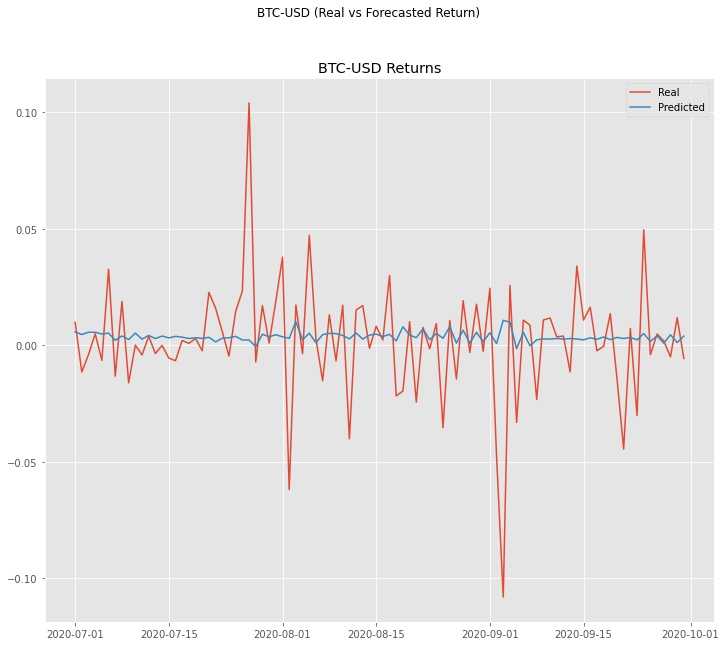

In [15]:
# BUY when the forecasted return is above 0 and SELL when the forecast 
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_rets = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
ret = 0

for ind in forecasted_rets.index:
    
    arma_btc_q2 = ARIMA(endog = ret_data['BTC']["2020-04-01" : ind - timedelta(days = 1)] , order = (1, 0, 1)).fit()
    forecasted_rets[ind] = arma_btc_q2.forecast()
    if forecasted_rets[ind] > 0:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real vs Forecasted Return)')
axs.plot(ret_data['BTC']["2020-07-01" : "2020-09-30"], label = "Real")
axs.plot(forecasted_rets, label = "Predicted")
axs.legend()
axs.set_title("BTC-USD Returns")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

In [16]:
# SECOND SCENARIO: Training on Q3 and benchmarking on Q4 

# Checking for stationarity
p_value_adf = adfuller(ret_data['BTC']["2020-07-01" : "2020-09-30"])[1]
if p_value_adf < 0.05:
    print("The series is stationary")
    btc_stationary_q3 = ret_data['BTC']["2020-07-01" : "2020-09-30"]

else:
    print("The series is not stationary")
    
    

The series is stationary


In [17]:
# Finding the best ARMA model based on AIC
## The auto_arima function below, iteratively checks values of p and q between 1 to 10, the assumptions
## are: Stationarity of the input data, and lack of any seasonality.

auto_arima(btc_stationary_q2, stationary=True, 
           start_p=1, max_p = 10, start_q = 1, 
           max_q = 10, seasonal = False, trace= True,
           information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-356.032, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-359.570, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-357.937, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-357.950, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-360.378, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.366 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

##### Interpretation of results:
The best reported model is a constant line, but for sake of verbosity we go with ARMA(1,1) model, since the reported AIC values does not have much difference.

In [18]:
# Fitting ARMA(1,1) model 
arma_btc_q3 = ARIMA(endog = btc_stationary_q3, order = (1, 0, 1)).fit()
arma_btc_q3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    BTC   No. Observations:                   92
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 211.613
Date:                Mon, 25 Oct 2021   AIC                           -415.227
Time:                        22:41:47   BIC                           -405.139
Sample:                    07-01-2020   HQIC                          -411.155
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.673      0.501      -0.003       0.007
ar.L1         -0.5081      0.715     -0.711      0.477      -1.909       0.893
ma.L1          0.3610      0.780      0.463      0.644      -1.169       1.890
sigma2         0.0006    5.5e-05     10.689      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               268.20
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.62
Prob(H) (two-sided):                  0.13   Kurtosis:                        11.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The return is: 86.40003800143283%
In and out of the Market Status:
Date
2020-10-01    1.0
2020-10-02    1.0
2020-10-03    1.0
2020-10-04    1.0
2020-10-05    1.0
             ... 
2020-12-27    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Length: 89, dtype: float64


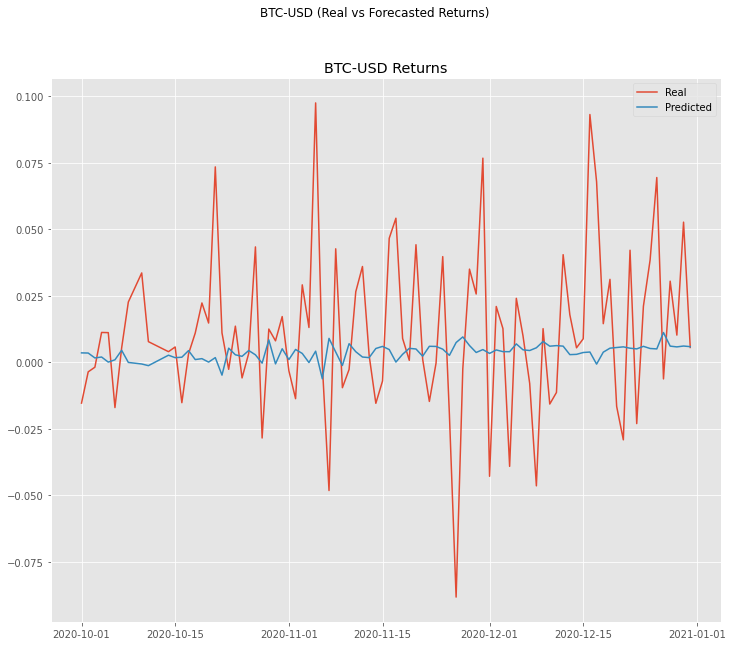

In [19]:
# BUY when the forecasted return is above 0 and SELL when the forecast 
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_rets = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
ret = 0

for ind in forecasted_rets.index:
    
    arma_btc_q3 = ARIMA(endog = ret_data['BTC']["2020-07-01" : ind - timedelta(days = 1)] , order = (1, 0, 1)).fit()
    forecasted_rets[ind] = arma_btc_q3.forecast()
    if forecasted_rets[ind] > 0:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real vs Forecasted Returns)')
axs.plot(ret_data['BTC']["2020-10-01" : "2020-12-31"], label = "Real")
axs.plot(forecasted_rets, label = "Predicted")
axs.legend()
axs.set_title("BTC-USD Returns")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

### 5.6 - The second strategy needs to include some form of GARCH.
Since we tested our data for stationarity and it passed, we will proceed with using PACF and ACF charts to find best MA and AR values for our GARCH model, and then fitting it and conducting forecasts.

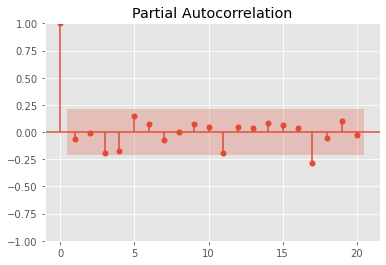

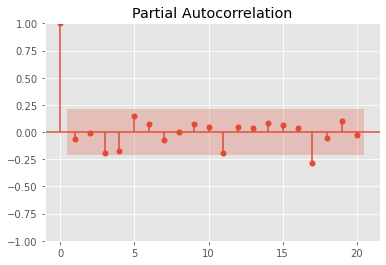

In [20]:
# FIRST SCENARIO: Training on Q2 and benchmarking on Q3 
plot_pacf(btc_stationary_q2)

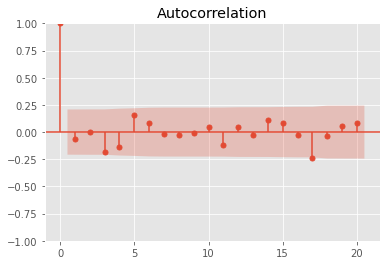

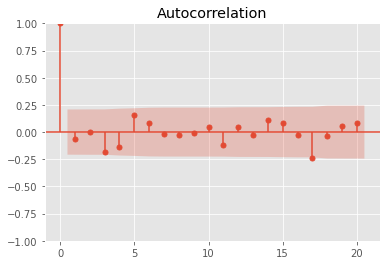

In [21]:
plot_acf(btc_stationary_q2)

##### Interpretation of results:
Much like our ARMA model, there is no clear indication of any MA or AR processes in our data, again for sake of context we go with GARCH(1, 1) and hope for the best.

We could use M-GARCH or an EGARCH model, but since GARCH seems more than enough for our data, to avoid any over-specification we only use the simple GARCH(1, 1) without any extra bits.

In [22]:
btc_garch_q2 = arch_model(y = btc_stationary_q2,
                          mean = "Constant", 
                          vol = "GARCH",
                          p =  1,
                          q = 1, 
                          dist = "normal")
btc_garch_q2.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -181.64095222672094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -181.64095409844754
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                181.641
Distribution:                  Normal   AIC:                          -355.282
Method:            Maximum Likelihood   BIC:                          -345.327
                                        No. Observations:                   89
Date:                Mon, Oct 25 2021   Df Residuals:                       88
Time:                        22:41:59   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.6443e-03  3.174e-03      1.148      0.251 

### Note:
We adopt a rolling forecast procedure, meaning that we fit the model again using the newly realized data points and then predict the next volatility of return. 

One has to pay attention that we are trying to predict volatilities, not the returns.

The return is: 16.595821508173536%
In and out of the Market Status:
Date
2020-07-01    1.0
2020-07-02    1.0
2020-07-03    1.0
2020-07-04    1.0
2020-07-05    1.0
             ... 
2020-09-26    1.0
2020-09-27    1.0
2020-09-28    1.0
2020-09-29    1.0
2020-09-30    1.0
Length: 92, dtype: float64


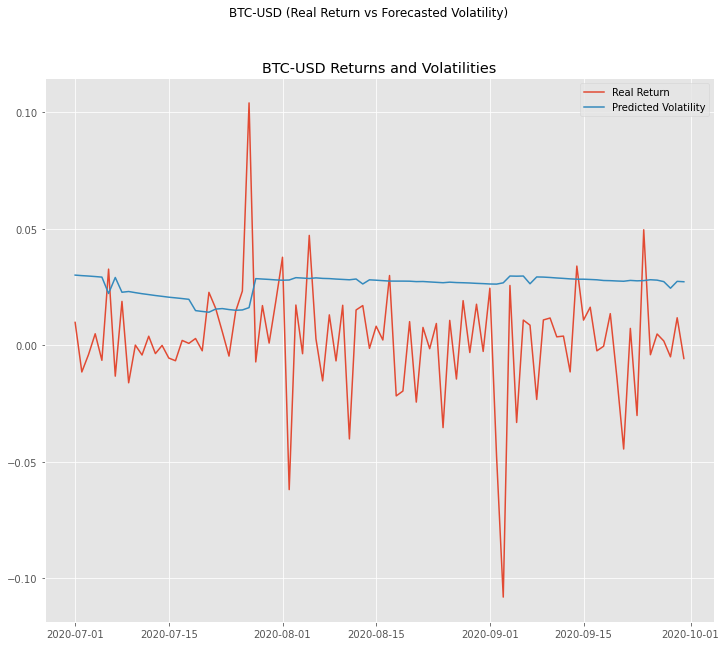

In [23]:
# BUY when the forecasted volatility is below 5%, Sell when it is above that
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_vols = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-07-01" : "2020-09-30"].index)
ret = 0

for ind in forecasted_vols.index:
    
    garch_btc_q2 = arch_model(y = ret_data['BTC']["2020-04-01" : ind - timedelta(days = 1)] , 
                              mean = "Constant", 
                              vol = "GARCH",
                              p =  1,
                              q = 1, 
                              dist = "normal").fit(disp = "off")
    forecasted_vols[ind] = np.sqrt(garch_btc_q2.forecast(horizon = 1).variance.values[-1][0])
    if float(forecasted_vols[ind]) < 0.05:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real Return vs Forecasted Volatility)')
axs.plot(ret_data['BTC']["2020-07-01" : "2020-09-30"], label = "Real Return")
axs.plot(forecasted_vols, label = "Predicted Volatility")
axs.legend()
axs.set_title("BTC-USD Returns and Volatilities")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

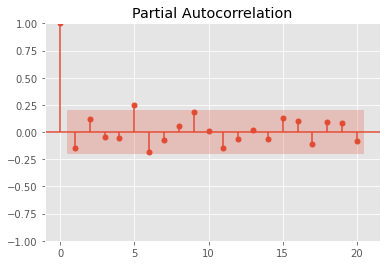

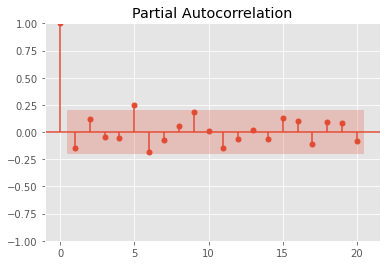

In [24]:
# SECOND SCENARIO: Training on Q3 and benchmarking on Q4 
plot_pacf(btc_stationary_q3)

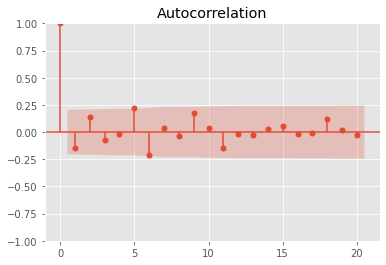

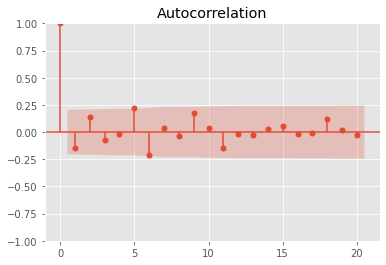

In [25]:
plot_acf(btc_stationary_q3)

##### Interpretation of results:
Much like our ARMA model, there is no clear indication of any MA or AR processes in our data, again for sake of context we go with GARCH(1, 1) and hope for the best.

We could use M-GARCH or an EGARCH model, but since GARCH seems more than enough for our data, to avoid any over-specification we only use the simple GARCH(1, 1) without any extra bits.

In [26]:
btc_garch_q3 = arch_model(y = btc_stationary_q3,
                          mean = "Constant", 
                          vol = "GARCH",
                          p =  1,
                          q = 1, 
                          dist = "normal")
btc_garch_q3.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 755854.6557409706
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1200.051187255217
Iteration:      3,   Func. Count:     23,   Neg. LLF: -215.88092629250684
Iteration:      4,   Func. Count:     29,   Neg. LLF: -125.29587422076537
Iteration:      5,   Func. Count:     35,   Neg. LLF: 19794.306845746032
Iteration:      6,   Func. Count:     41,   Neg. LLF: -197.6612324053192
Iteration:      7,   Func. Count:     47,   Neg. LLF: -219.21911316856108
Iteration:      8,   Func. Count:     53,   Neg. LLF: -221.23971610753446
Iteration:      9,   Func. Count:     58,   Neg. LLF: -221.19785423560643
Iteration:     10,   Func. Count:     64,   Neg. LLF: -88.33415935019745
Iteration:     11,   Func. Count:     72,   Neg. LLF: -221.24741426394783
Iteration:     12,   Func. Count:     77,   Neg. LLF: -221.24844260668874
Iteration:     13,   Func. Count:     82,   Neg. LLF: -221.24844362008102
Iteration:     14,   Func. Count:     86,   N

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    BTC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                221.248
Distribution:                  Normal   AIC:                          -434.497
Method:            Maximum Likelihood   BIC:                          -424.410
                                        No. Observations:                   92
Date:                Mon, Oct 25 2021   Df Residuals:                       91
Time:                        22:42:02   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.6051e-03  1.265e-03      1.269      0.205 

The return is: 98.15047526801717%
In and out of the Market Status:
Date
2020-10-01    1.0
2020-10-02    1.0
2020-10-03    1.0
2020-10-04    1.0
2020-10-05    1.0
             ... 
2020-12-27    1.0
2020-12-28    1.0
2020-12-29    1.0
2020-12-30    1.0
2020-12-31    1.0
Length: 89, dtype: float64


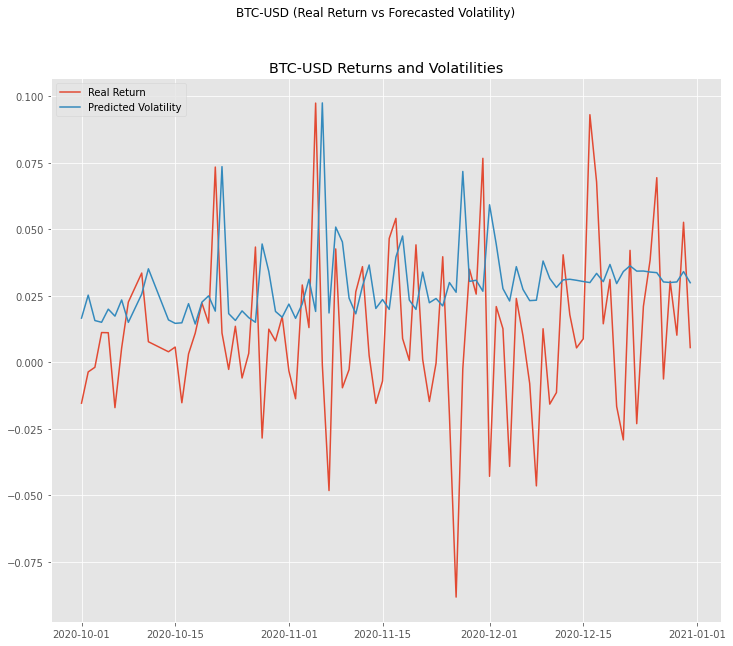

In [27]:
# BUY when the forecasted volatility is below 5%, Sell when it is above that
## Iterating through the data for forecasting and portfolio calculation
### Since we have log returns, we can simply add them up

forecasted_vols = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
in_or_out_of_market = pd.Series(index = ret_data['BTC']["2020-10-01" : "2020-12-31"].index)
ret = 0

for ind in forecasted_vols.index:
    
    garch_btc_q3 = arch_model(y = ret_data['BTC']["2020-07-01" : ind - timedelta(days = 1)] , 
                              mean = "Constant", 
                              vol = "GARCH",
                              p =  1,
                              q = 1, 
                              dist = "normal").fit(disp = "off")
    forecasted_vols[ind] = np.sqrt(garch_btc_q3.forecast(horizon = 1).variance.values[-1][0])
    if float(forecasted_vols[ind]) < 0.05:
        ret += ret_data['BTC'][ind]
        in_or_out_of_market[ind] = 1 # One indicates being IN THE MARKET
    else:
        in_or_out_of_market[ind] = 0 # Zero indicates being OUT OF THE MARKET
        
fig, axs = plt.subplots(1, figsize = (12, 10) )
fig.suptitle('BTC-USD (Real Return vs Forecasted Volatility)')
axs.plot(ret_data['BTC']["2020-10-01" : "2020-12-31"], label = "Real Return")
axs.plot(forecasted_vols, label = "Predicted Volatility")
axs.legend()
axs.set_title("BTC-USD Returns and Volatilities")

print("The return is: {}%".format(ret*100))
print("In and out of the Market Status:")
print(in_or_out_of_market)

### 5.7 Which of the 2 models do you prefer?  Explain your answer in quantitative terms.

Based on the calculated returns, we can see that our ARMA model outperforms the GARCH during Q3, but GARCH startegy beats ARMA in the Q4. Beside a ton of hyperparameters in our startegies that can change our end results and subsequently our interpretations, we are can say that reagradless of startegy settings, GARCH model is much better than ARMA in predicting volatility of returns during high fluctuations, which is implicit in the p-values of parameters or GARCH nad ARMA when fitting on Q3 data and predicting Q4. And we know most of the high fluctuation periods are due to bad news or namely "corrections" in the market as an stylized fact, in other words, there are steady growth periods and chaotic corrections or crashes. By utilizing a risk averse strategy based on GARCH rather than merely trying to predict the unpredictable with an ARMA, we ended up with better ROI. And if we add up ROI of the models during the two trading periods, we can see that in total GARCH wins.

Therefore our preference goes to GARCH.

## 6. Category 2 Models

- Use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction. <br/>
We continue to use the Bitcoin series and <b>use VGK returns as the exogeneous varaiable</b>.


### 6.1 - 6.2 - 6.3 - 6.4

- (6.1) Use the same series as you did in the previous question<br/>
_(Note: we already know from Section 5 that the input BTC series is stationary. Below, we confirm that VGK series is stationary as well.)_

- (6.2) Use Q2 data for estimation, and Q3 data for evaluating performance.
- (6.3) Repeat, using Q3 data for estimation, and Q4 data for evaluating performance

- (6.4) Build 3 trading strategies<br/>
<b>(Selected strategies: VAR, ARMA-GARCH, Pairs Trading)</b>

In [28]:
# Datasets
q2_returns = get_data(ret_data, 2020, 2020, 4, 7)
q3_returns = get_data(ret_data, 2020, 2020, 7, 10)
q4_returns = get_data(ret_data, 2020, 2021, 10, 1)

cols = ['BTC','VGK']
q4_returns[cols]

,BTC,VGK
Date,,
2020-10-01,-0.015346,0.007789
2020-10-02,-0.003599,-0.000378
2020-10-03,-0.001860,0.000000
2020-10-04,0.011194,0.000000
2020-10-05,0.011129,0.017826
...,...,...
2020-12-27,-0.006251,0.000000
2020-12-28,0.030458,0.006789
2020-12-29,0.010198,0.007235


In [29]:
# Checking VGK series for stationarity (Quarter 2 to Quarter 4)

vgk_returns = get_data(ret_data, 2020, 2021, 4, 1).VGK

p_value_adf = adfuller(vgk_returns)[1]
if p_value_adf < 0.05:
    print("The series of VGK returns is stationary.")
else:
    print("The series of VGK returns is not stationary.")

The series of VGK returns is stationary.


### 6.5 The 1st strategy should include a form of VAR or VARMA.  (Selected model: VAR)

To build the VAR trading strategy, we **fit the VAR model to predict the future returns**. 

The trading strategy works as such: **If the predicted 1-day return is more than zero, we develop a simple long-only trading strategy that buys 1 unit of BTC, holds it for a day and sells it at Market Close the day after.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

In [30]:
def fit_VAR(dataset):
    var_result = VAR(endog = dataset[cols].values)
    var_lag_selection = var_result.select_order(maxlags=10)
    
    best_lag = var_lag_selection.selected_orders['aic']
    print(f'Best lag value: {best_lag}\n')
    return var_lag_selection.summary(), var_result.fit(best_lag+1)

def rolling_forecast_VAR(var_model, train, predict):
    datapoints = train[cols].values[-1:]
    forecasts = []
    for actual_btc in predict[cols].values:        
        forecasts.append(var_model.forecast(datapoints, steps=1)[0][0])        
        datapoints = np.array([actual_btc])               
    return forecasts

def plot_forecast_vs_actual(result_df, model_name, quarter):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(result_df.Actual, label = "Actual")
    ax.plot(result_df.Predicted, label = "Predicted")
    ax.legend()
    ax.set_ylabel('BTC Returns')
    plt.title(f"{model_name} - BTC Forecasted vs Actual Returns (Q{quarter})")
    plt.show()
    
def evaluate_strategy(result_df, buy_threshold=0):
    returns = []
    for forecast, actual in result_df.values:
        if forecast > buy_threshold:
            returns.append(actual)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return np.where(result_df.Predicted > buy_threshold, 1, 0)

#### VAR strategy (Train on Q2, Evaluate on Q3)


In [31]:
# Q2 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q2_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-15.35*,-15.29*,2.153e-07*,-15.33*
1,-15.32,-15.14,2.230e-07,-15.24
2,-15.27,-14.97,2.334e-07,-15.15
3,-15.21,-14.79,2.482e-07,-15.04
4,-15.19,-14.65,2.535e-07,-14.97
5,-15.13,-14.47,2.696e-07,-14.87
6,-15.07,-14.29,2.880e-07,-14.75
7,-14.98,-14.08,3.158e-07,-14.62
8,-14.91,-13.89,3.398e-07,-14.50
9,-14.84,-13.70,3.665e-07,-14.38


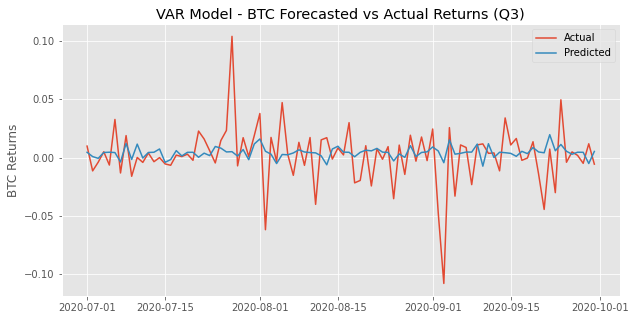

Total Returns: 27.80%
Q3 Long-only Strategy of 92 days (1 for long signal, 0 for no action):


array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1])

In [32]:
forecast_df = pd.DataFrame({
    "Actual": q3_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q2_returns, q3_returns)
}, index = q3_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 3)

q3_long_strategy = evaluate_strategy(forecast_df)
print('Q3 Long-only Strategy of', len(q3_returns), "days (1 for long signal, 0 for no action):")
q3_long_strategy

In [33]:
# Q3 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q3_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-16.78*,-16.72*,5.144e-08*,-16.76*
1,-16.77,-16.59,5.228e-08,-16.70
2,-16.72,-16.43,5.485e-08,-16.60
3,-16.62,-16.21,6.034e-08,-16.46
4,-16.59,-16.06,6.238e-08,-16.38
5,-16.55,-15.91,6.489e-08,-16.29
6,-16.49,-15.73,6.906e-08,-16.19
7,-16.41,-15.53,7.524e-08,-16.06
8,-16.33,-15.33,8.203e-08,-15.93
9,-16.28,-15.16,8.674e-08,-15.83


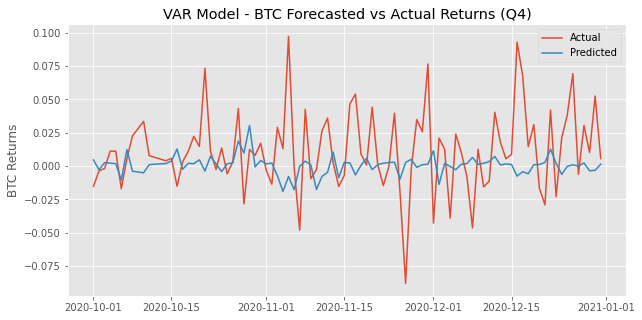

Total Returns: 3.29%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1])

In [34]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

In [35]:
# Q3 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q3_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-16.78*,-16.72*,5.144e-08*,-16.76*
1,-16.77,-16.59,5.228e-08,-16.70
2,-16.72,-16.43,5.485e-08,-16.60
3,-16.62,-16.21,6.034e-08,-16.46
4,-16.59,-16.06,6.238e-08,-16.38
5,-16.55,-15.91,6.489e-08,-16.29
6,-16.49,-15.73,6.906e-08,-16.19
7,-16.41,-15.53,7.524e-08,-16.06
8,-16.33,-15.33,8.203e-08,-15.93
9,-16.28,-15.16,8.674e-08,-15.83


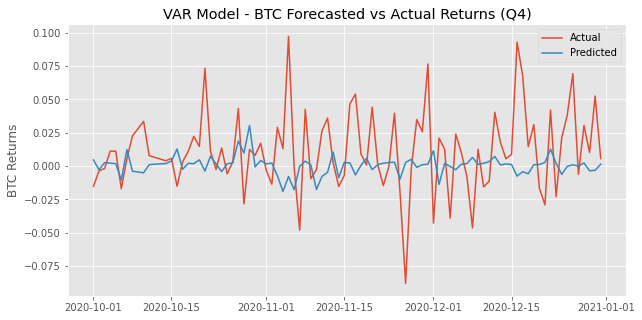

Total Returns: 3.29%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1])

In [36]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

### 6.6 The 2nd strategy should include multivariate GARCH.  There are several possibilities.  (Selected model: ARMA-GARCH)

To build this trading strategy, we **fit the GARCH model on ARMA residuals** to arrive at the ARMA-GARCH model. 

The trading strategy works as such: **If the predicted 1-day return is more than zero, we develop a simple long-only trading strategy that buys 1 unit of BTC, holds it for a day and sells it at Market Close the day after.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

In [37]:
def perform_1d_arma_garch_forecast(series, exog): 
    # Best p = 1, best q = 1   - from auto_arima(series, exog=exog, trace=True) 
    arima_model = ARIMA(series, exog=exog, order=(1,0,1)).fit()
    
    # Fit GARCH(1,1) model on the residuals of the ARIMA model
    garch = arch.arch_model(arima_model.resid, vol='GARCH', p=1, q=1).fit(disp="off")
    
    # Use ARIMA to predict mu, GARCH to predict residual
    mu, garch_resid = arima_model.predict(n_periods=1)[0], garch.forecast(horizon=1).mean['h.1'].iloc[-1]
    return mu + garch_resid

def rolling_forecast_arma_garch(train, predict, n=90):
    df = pd.concat([train, predict])[cols]
    return [perform_1d_arma_garch_forecast(df[:date][-1-n:-1].BTC, df[:date][-91:-1].VGK) for date in predict.index]

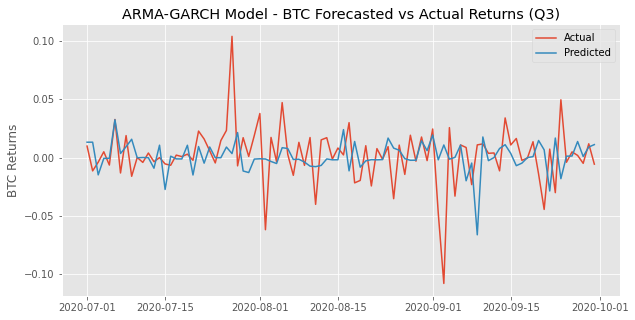

Total Returns: 6.12%
Q3 Long-only Strategy of 92 days (1 for long signal, 0 for no action):


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [38]:
forecast_df = pd.DataFrame({
    "Actual": q3_returns.BTC,
    "Predicted": rolling_forecast_arma_garch(q2_returns, q3_returns)
}, index = q3_returns.index)

plot_forecast_vs_actual(forecast_df, 'ARMA-GARCH Model', 3)
q3_long_strategy = evaluate_strategy(forecast_df, buy_threshold=0.02)
print('Q3 Long-only Strategy of', len(q3_returns), "days (1 for long signal, 0 for no action):")
q3_long_strategy

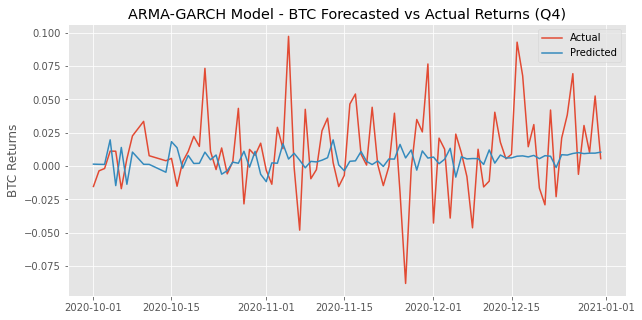

Total Returns: 28.15%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1])

In [39]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_arma_garch(q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'ARMA-GARCH Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

### 6.7 The 3rd strategy should attempt to include cointegration. (Selected Strategy: Pairs Trading)

Before building this trading strategy, we first establish that **BTC and VGK returns are cointegrated** using the Engle-Granger test, which suggests that this pair has a long-run statistically significant relationship and verifies this necessary assumption of the pairs trading strategy.

The pairs trading strategy leverages on this cointegration relationship in this way: **If the BTC return is negative while VGK return is positive, we develop a simple long-only trading strategy that buys 1 unit of BTC at Market Open the next day and sell it at Market Close the same day.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

One limitation of this naive approach is that the holding period of each position is only 1 day, which may not be sufficient time for the mean-reversion phenomenon to take place.

In [40]:
def perform_engle_granger(dataset):
    t_coint, p_value, crit_vals = coint(
        y0 = dataset.BTC, y1 = dataset.VGK, trend = "ct", autolag = "aic"
    )
    sig = p_value <= 0.05
    print(f"BTC & VGK are {'' if sig else 'not '}cointegrated. {'p-value = {:,.5f}'.format(p_value)}")
    
q2q4_df = pd.concat([q2_returns, q3_returns, q4_returns])
perform_engle_granger(q2q4_df[cols])

BTC & VGK are cointegrated. p-value = 0.00000


In [41]:
def evaluate_pairs_trading_strategy(returns_df):
    signals = []
    returns = []
    for btc_return, vgk_return in returns_df.values[:-1]:
        if len(signals) > 0 and signals[-1] == 1:
            returns.append(btc_return)
        signals.append(1 if btc_return < 0 and vgk_return > 0 else 0)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return signals

In [42]:
q3_df = pd.concat([q2_returns, q3_returns]).tail(len(q3_returns)+1)[cols]
q3_strategy = evaluate_pairs_trading_strategy(q3_df)
print(q3_strategy)

Total Returns: -1.20%
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


In [43]:
q4_df = pd.concat([q3_returns, q4_returns]).tail(len(q4_returns)+1)[cols]
q4_strategy = evaluate_pairs_trading_strategy(q4_df)
print(q4_strategy)

Total Returns: 4.32%
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


### 6.8 Which of the 5 models do you prefer?  Explain your answer in quantitative terms


Adding up the ROI from each of the 5 models over Q3 and Q4, the winner is the GARCH model.

To expound on the quantitative aspect, we first identify that the pairs trading, while promising, requires a more sophisticated strategy with longer holding period for such a mean-reversion to be effective. For the VAR model, it is unfortunately not comprehensive due to the volatility clustering phenomenon which can lead to unexpected market behavior that defies the assumptions of the model. The best model candidate for this section (in terms of combined ROI as well) is the ARMA-GARCH model, but it pales in comparison to the GARCH model due to a stark difference in key principles: while ARMA GARCH is easily an improvement over ARMA due to the additional training step on residuals, the pure GARCH model directly combats the phenomenon of volatility clustering where returns exhibit a change in variance over time, and this best optimises forecasting performance.

As such, our preference thus far still goes to GARCH.

## 7. Category 3 Models: Use all 3 variables: the one you are trading

- Use 3 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction. <br/>
We continue to use the Bitcoin series and <b>use VGK returns as the exogeneous varaiable</b>.


### 6.1 - 6.2 - 6.3 - 6.4

- (7.1) Use the same series as you did in the previous question<br/>
_(Note: we already know from Section 6 that the input BTC series is stationary. Below, we confirm that VGK series is stationary as well.)_

- (7.2) Use Q2 data for estimation, and Q3 data for evaluating performance.
- (7.3) Repeat, using Q3 data for estimation, and Q4 data for evaluating performance

- (7.4) Build 3 trading strategies<br/>
<b>(Selected strategies: VARMA, ARMA-GARCH, Pairs Trading)</b>

In [52]:
# Datasets
q2_returns = get_data(ret_data, 2020, 2020, 4, 7)
q3_returns = get_data(ret_data, 2020, 2020, 7, 10)
q4_returns = get_data(ret_data, 2020, 2021, 10, 1)

cols = ['BTC','VGK', 'GLD']
q4_returns[cols]

,BTC,VGK,GLD
Date,,,
2020-10-01,-0.015346,0.007789,0.008881
2020-10-02,-0.003599,-0.000378,-0.000896
2020-10-03,-0.001860,0.000000,0.000000
2020-10-04,0.011194,0.000000,0.000000
2020-10-05,0.011129,0.017826,0.004861
...,...,...,...
2020-12-27,-0.006251,0.000000,0.000000
2020-12-28,0.030458,0.006789,-0.003636
2020-12-29,0.010198,0.007235,0.003636


In [53]:
# Checking VGK series for stationarity (Quarter 2 to Quarter 4)

vgk_returns = get_data(ret_data, 2020, 2021, 4, 1).VGK

p_value_adf = adfuller(vgk_returns)[1]
if p_value_adf < 0.05:
    print("The series of VGK returns is stationary.")
else:
    print("The series of VGK returns is not stationary.")

The series of VGK returns is stationary.


### 7.5 The 1st strategy should include a form of VAR or VARMA.  (Selected model: VARMA)

To build the VARMA trading strategy, we **fit the VARMA model to predict the future returns**. 

The trading strategy works as such: **If the predicted 1-day return is more than zero, we develop a simple long-only trading strategy that buys 1 unit of BTC, holds it for a day and sells it at Market Close the day after.** To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

#### VAR strategy (Train on Q2, Evaluate on Q3)


In [54]:
# Q2 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q2_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-25.23*,-25.14*,1.100e-11*,-25.20*
1,-25.21,-24.85,1.130e-11,-25.06
2,-25.13,-24.50,1.221e-11,-24.88
3,-24.99,-24.09,1.403e-11,-24.63
4,-25.01,-23.84,1.388e-11,-24.54
5,-24.96,-23.52,1.474e-11,-24.38
6,-24.82,-23.11,1.712e-11,-24.13
7,-24.69,-22.71,1.975e-11,-23.90
8,-24.54,-22.29,2.348e-11,-23.64
9,-24.49,-21.97,2.540e-11,-23.48


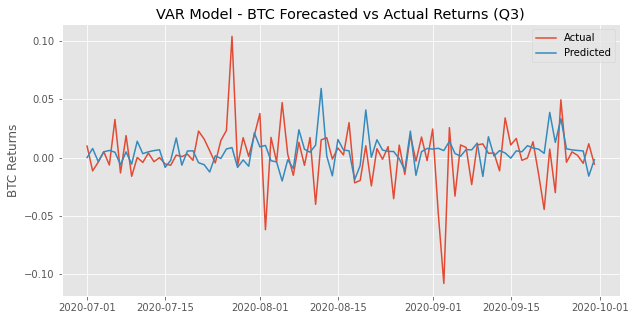

Total Returns: 37.33%
Q3 Long-only Strategy of 92 days (1 for long signal, 0 for no action):


array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0])

In [55]:
forecast_df = pd.DataFrame({
    "Actual": q3_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q2_returns, q3_returns)
}, index = q3_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 3)

q3_long_strategy = evaluate_strategy(forecast_df)
print('Q3 Long-only Strategy of', len(q3_returns), "days (1 for long signal, 0 for no action):")
q3_long_strategy

In [56]:
# Q3 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q3_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-26.09*,-26.00*,4.665e-12*,-26.06*
1,-26.03,-25.68,4.941e-12,-25.89
2,-25.89,-25.27,5.708e-12,-25.64
3,-25.68,-24.80,7.033e-12,-25.33
4,-25.60,-24.45,7.698e-12,-25.14
5,-25.46,-24.05,8.899e-12,-24.89
6,-25.32,-23.65,1.032e-11,-24.65
7,-25.25,-23.31,1.130e-11,-24.47
8,-25.21,-23.00,1.201e-11,-24.32
9,-25.09,-22.63,1.377e-11,-24.10


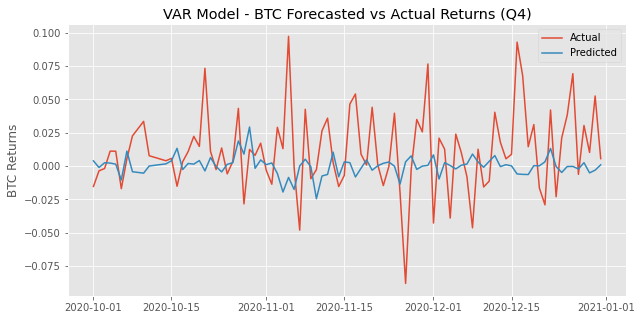

Total Returns: 1.50%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1])

In [57]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

In [58]:
# Q3 dataset: Determine best lag value based on AIC

var_selection, var_model = fit_VAR(q3_returns)
var_selection

Best lag value: 0



,AIC,BIC,FPE,HQIC
0,-26.09*,-26.00*,4.665e-12*,-26.06*
1,-26.03,-25.68,4.941e-12,-25.89
2,-25.89,-25.27,5.708e-12,-25.64
3,-25.68,-24.80,7.033e-12,-25.33
4,-25.60,-24.45,7.698e-12,-25.14
5,-25.46,-24.05,8.899e-12,-24.89
6,-25.32,-23.65,1.032e-11,-24.65
7,-25.25,-23.31,1.130e-11,-24.47
8,-25.21,-23.00,1.201e-11,-24.32
9,-25.09,-22.63,1.377e-11,-24.10


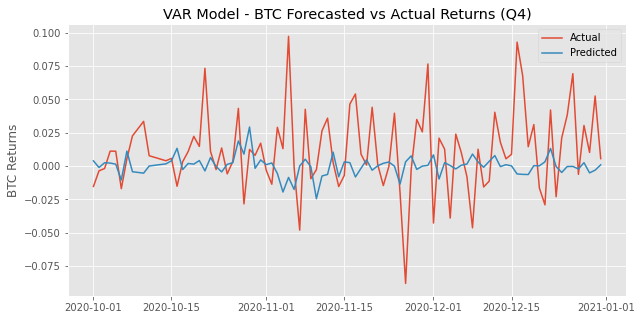

Total Returns: 1.50%
Q4 Long-only Strategy of 89 days (1 for long signal, 0 for no action):


array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1])

In [59]:
forecast_df = pd.DataFrame({
    "Actual": q4_returns.BTC,
    "Predicted": rolling_forecast_VAR(var_model, q3_returns, q4_returns)
}, index = q4_returns.index)

plot_forecast_vs_actual(forecast_df, 'VAR Model', 4)

q4_long_strategy = evaluate_strategy(forecast_df)
print('Q4 Long-only Strategy of', len(q4_returns), "days (1 for long signal, 0 for no action):")
q4_long_strategy

### 7.6 The 2nd strategy should attempt to include cointegration.  

Note there can be cointegration between (y, x1);  or (y; x2);  or(y, x1, x2).  If none of these cointegrations exists, then justify the lack of existence for cointegration in quantitative terms.

Before building this trading strategy, we first establish that **(BTC, VGK), (BTC, GLD) returns are cointegrated** using the Engle-Granger test, which suggests that this pair has a long-run statistically significant relationship and verifies this necessary assumption of the pairs trading strategy.

The pairs trading strategy leverages on this cointegration relationship in this way: 
We develope **a simple long-only trading strategy that  Asset class in **
**If the BTC_returns < 0 && VGK_returns > 0, buys 1 unit of BTC at Market Open the next day and sell it at Market Close the same day.**
**If the BTC_returns < 0 && GLD_returns > 0, buys 1 unit of BTC at Market Open the next day and sell it at Market Close the same day.**

To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

One limitation of this naive approach is that the holding period of each position is only 1 day, which may not be sufficient time for the mean-reversion phenomenon to take place.

In [66]:
def perform_engle_granger(ds1_name, dataset1, ds2_name, dataset2):
    t_coint, p_value, crit_vals = coint(
        y0 = dataset1, y1 = dataset2, trend = "ct", autolag = "aic"
    )
    sig = p_value <= 0.05
    print(f"{ds1_name} & {ds2_name} are {'' if sig else 'not '}cointegrated. {'p-value = {:,.5f}'.format(p_value)}")
    
q2q4_df = pd.concat([q2_returns, q3_returns, q4_returns])
perform_engle_granger('BTC', q2q4_df[cols].BTC, 'VGK', q2q4_df[cols].VGK)

BTC & VGK are cointegrated. p-value = 0.00000


In [67]:
perform_engle_granger('BTC', q2q4_df[cols].BTC, 'VGK', q2q4_df[cols].VGK)

BTC & VGK are cointegrated. p-value = 0.00000


In [74]:
def evaluate_pairs_trading_strategy(returns_df, ASSET1, ASSET2):
    signals = []
    returns = []
    for asset1_return, asset2_return in zip(returns_df[ASSET1].values[:-1], returns_df[ASSET2].values[:-1]):
        if len(signals) > 0 and signals[-1] == 1:
            returns.append(asset1_return)
        signals.append(1 if asset1_return < 0 and asset2_return > 0 else 0)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return signals

In [75]:
q3_df = pd.concat([q2_returns, q3_returns]).tail(len(q3_returns)+1)[cols]
q3_strategy = evaluate_pairs_trading_strategy(q3_df, 'BTC', 'VGK')
print(q3_strategy)

Total Returns: -1.20%
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


In [76]:
perform_engle_granger('BTC', q2q4_df[cols].BTC, 'GLD', q2q4_df[cols].GLD)

BTC & GLD are cointegrated. p-value = 0.00000


In [77]:
q3_strategy = evaluate_pairs_trading_strategy(q3_df, 'BTC', 'GLD')
print(q3_strategy)

Total Returns: 15.51%
[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


### 7.6.3 cointegration between BTC and (VGK, GLD).  

Note there can be cointegration between (y, x1);  or (y; x2);  or(y, x1, x2).  If none of these cointegrations exists, then justify the lack of existence for cointegration in quantitative terms.

Before building this trading strategy, we first establish that **(BTC -> (VGK,GLD)) returns are cointegrated using the Johansen Test** which suggests that BTC -> mixed portfolio of VGK and GLD pair has a long-run statistically significant relationship and verifies this necessary assumption of the pairs trading strategy.

The pairs trading strategy leverages on this cointegration relationship in this way: 
We develope **a simple long-only trading strategy that  Asset class in **
**If the BTC_returns < 0 && VGK_GLD_returns > 0, buys 1 unit of BTC at Market Open the next day and sell it at Market Close the same day.**

To evaluate this strategy, we plot the forecasted vs actual returns, and compute the total return for periods Q3 and Q4 (model trained on Q2 and Q3 respectively).

One limitation of this naive approach is that the holding period of each position is only 1 day, which may not be sufficient time for the mean-reversion phenomenon to take place.

In [96]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def jo_result_interpreter(result):
       
    for i in range(len(result.ind)):
        print("")
        print("NULL HYPO: coint relations = {} | ALT HYPO: coint relations > {}".format(result.ind[i], result.ind[i]))
        print("trace ------ 90% -- 95% -- 99%")
        print("{} -- {}".format(np.round(result.trace_stat[i], 3), result.trace_stat_crit_vals[i]))
        if result.trace_stat[i] >= result.trace_stat_crit_vals[i][1]:
            print('---------REJECTED!---------')
            print("")
        else:
            print('---------NOT REJECTED!---------')
            print("")
            print("We have {} cointegration relations.".format(i))
            break    


def perform_johansen_test(dataset):
    johansen_test_result = coint_johansen(
        endog = dataset, det_order=1, k_ar_diff=5)
    
    output = pd.DataFrame([johansen_test_result.lr2,johansen_test_result.lr1],
                   index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n", johansen_test_result.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n", johansen_test_result.cvt,'\n')
    jo_result_interpreter(johansen_test_result)
    
    
q2q4_df = pd.concat([q2_returns, q3_returns, q4_returns])
perform_johansen_test(q2q4_df[cols])

   max_eig_stat  trace_stat
0     58.984058  146.668743
1     52.952014   87.684685
2     34.732671   34.732671 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] 


NULL HYPO: coint relations = 0 | ALT HYPO: coint relations > 0
trace ------ 90% -- 95% -- 99%
146.669 -- [32.0645 35.0116 41.0815]
---------REJECTED!---------


NULL HYPO: coint relations = 1 | ALT HYPO: coint relations > 1
trace ------ 90% -- 95% -- 99%
87.685 -- [16.1619 18.3985 23.1485]
---------REJECTED!---------


NULL HYPO: coint relations = 2 | ALT HYPO: coint relations > 2
trace ------ 90% -- 95% -- 99%
34.733 -- [2.7055 3.8415 6.6349]
---------REJECTED!---------



In [93]:
def evaluate_complex_3_var_trading_strategy(returns_df):
    signals = []
    returns = []
    for asset1_return, asset2_return, asset3_return in returns_df.values[:-1]:
        if len(signals) > 0 and signals[-1] == 1:
            returns.append(asset1_return)
        combined_returns = asset2_return * 0.5 + asset3_return * 0.5  
        signals.append(1 if asset1_return < 0 and combined_returns > 0 else 0)
    print("Total Returns: {:.2f}%".format(sum(returns) * 100))
    return signals

**Since the higher order cointegration is rejected between the BTC and (VGK,GLD) using the Johansen Test we can not calculate the strategy performance for this mixed asset class strategy. The forcefull calculation of the strategy gives us the -0.49% returns.

In [95]:
q3_strategy = evaluate_complex_3_var_trading_strategy(q3_df)
print(q3_strategy)

Total Returns: -0.49%
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


### 7.8 The 3rd strategy should attempt to include an error-correction model (ECM). 
This will only work if there is cointegration in the previous part.

As we have seen in 7.6 there does notexists in cointegration between BTC, VGK and GLD.


## 8 Combining the models

In order to come up with the best strategy to create optimal portfolio its must to use the combination of models which have different properties such as returns, risk and maximum draw downs. Due to the limited data set and the simplcity in the models we are using only 1 parameter Risk to justify and allocated the weitage to the multiple strategies.

### 8.1 Models worked well, assign relative weights to Models

Taking a look at the returns for the all 8 models that we delveloped based on the consitent returns and the -ve returns seen in one of the two quarters in some of the models, below models are good model

| Point | Model               | Q2 ret  | Q3 returns |
| ----- | ------------------- | ------- | ---------- |
| 5.5   | ARMA                | 19.75%  | 86.40%     |
| 5.6   | GARCH               | 16.59%  | 98.15%     |
| 6.5   | VAR - 2 Variables   | 27.8%   | 3.29%      |
| 6.6   | GARCH - 2 Variables | 6.12%   | 28.15%     |
| 6.7   | Coint- 2 Variables  | \-1.20% | 4.32%      |
| 7.5   | VAR - 3 Variables   | 37.33%  | 1.50%      |
| 7.6   | Coint- 3 Variables  | \-1.20% | 15.51%     |


Based on the above returns for all the models, the first three models 5.5 ARMA, 5.6 GARCH and 6.5 VAR-2 Variables models are the best models for the returns.

### 8.2 Derive an overall model that uses each selected model times its relative weight.

Since the best 3 chosen models have different features, parameters, methods and characterstics, they are meant to perform different under the different market conditions and for the perfectly hedge protfolio and to make our model robust we can allocated relative weight to the particular model either to invest or derive the trading singal for the confirmance of the signal. We chose to allocated the weighatge to the particular model in terms of the investing with respect to the determining the strength of the signal by allocating weightage to the signal.

In [7]:
def combined_model_with_weightage(arma_forecast, garch_forcast, var2_forcast, arma_w, garch_w, var2_w,):
    return arma_forecast * arma_w + garch_forcast * garch_w + var2_forcast * var2_w


def calculate_best_returns(Q, arma_forecast, garch_forcast, var2_forcast):
    relative_weights = [x/10 for x in range(0,11)]
    max_returns = 0
    for arma_w in relative_weights:
        for garch_w in relative_weights:
            if arma_w + garch_w > 1:
                continue                
            var2_w = 1 - arma_w - garch_w
            current_returns = combined_model_with_weightage(arma_forecast, garch_forcast, var2_forcast, arma_w, garch_w, var2_w,)
            if current_returns > max_returns:
                max_returns = current_returns
                print(f'{Q}, Max returns: {max_returns} [Arma_Weightage: {arma_w}], [GARCH_Weightage: {garch_w}], [VAR2_Weightage: {var2_w}]')

                
arma_q2_forecasted_returns = 19.75
garch_q2_forecasted_returns = 16.59
var2_q2_forecasted_returns = 27.8         
arma_q3_forecasted_returns = 86.40
garch_q3_forecasted_returns = 98.15
var2_q3_forecasted_returns = 3.29        

calculate_best_returns('Quarter 3', arma_q2_forecasted_returns,garch_q2_forecasted_returns,var2_q2_forecasted_returns)
calculate_best_returns('Quarter 4', arma_q3_forecasted_returns,garch_q3_forecasted_returns,var2_q3_forecasted_returns)


Quarter 2, Max returns: 27.8 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.0], [VAR2_Weightage: 1.0]
Quarter 3, Max returns: 3.29 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.0], [VAR2_Weightage: 1.0]
Quarter 3, Max returns: 12.776000000000002 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.1], [VAR2_Weightage: 0.9]
Quarter 3, Max returns: 22.262000000000004 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.2], [VAR2_Weightage: 0.8]
Quarter 3, Max returns: 31.748 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.3], [VAR2_Weightage: 0.7]
Quarter 3, Max returns: 41.234 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.4], [VAR2_Weightage: 0.6]
Quarter 3, Max returns: 50.720000000000006 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.5], [VAR2_Weightage: 0.5]
Quarter 3, Max returns: 60.206 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.6], [VAR2_Weightage: 0.4]
Quarter 3, Max returns: 69.692 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.7], [VAR2_Weightage: 0.30000000000000004]
Quarter 3, Max returns: 79.17800000000001 [Arma_Weig

From the results it seems like for the Q3 forecasted returns weightage of 27.8 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.0], [VAR2_Weightage: 1.0] works good.

While for the Quarter 4, the mixed weightages give different results but for the purpose of balanced trading strategy we could select any of among top 3
Quarter 3, Max returns: 79.17800000000001 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.8], [VAR2_Weightage: 0.19999999999999996]
Quarter 3, Max returns: 88.664 [Arma_Weightage: 0.0], [GARCH_Weightage: 0.9], [VAR2_Weightage: 0.09999999999999998]
Quarter 3, Max returns: 98.15 [Arma_Weightage: 0.0], [GARCH_Weightage: 1.0], [VAR2_Weightage: 0.0]

### 8.3 combined model compare to the individual models

Even though in our case the the GARCH model is slightly performing better than the ARMA model, in Quarter 3 the VAR model is performing significantly better than the rest two. While we can combine models to get significant more returns we have to also consider the other factors about how to combine the models for better
